In [ ]:
!nvidia-smi

Mon Sep 12 12:36:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#load drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import shutil
import cv2

from glob import glob
from PIL import Image
from keras import backend as K
from keras.models import Model
from keras.optimizer_v2.adam import Adam
from keras.layers import concatenate
from keras.layers import BatchNormalization 
from keras.layers import Activation
from keras.layers import Conv2DTranspose
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from albumentations import *
from keras.models import load_model

In [ ]:

print(tf.__version__)

2.8.2


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 240, 240, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 240, 240, 16  64         ['conv2d_38[0][0]']              
 ormalization)                  )                                                           

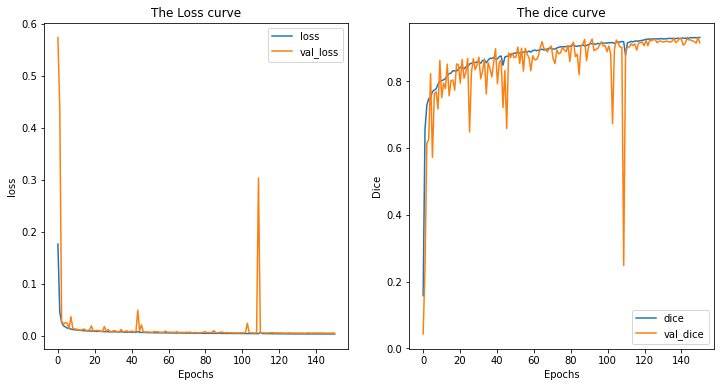

In [ ]:
class U_Net():
    def __init__(self):
        # init the parameters and inputs
        self.height = 240
        self.width = 240
        self.channels = 1
        self.shape = (self.height, self.width, self.channels)

        # optimizer
        optimizer = Adam(0.002, 0.5)

        # u_net
        self.unet = self.build_unet()  # create a model
        self.unet.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=[self.dice_score])
        self.unet.summary()

    def build_unet(self, n_filters=16, dropout=0.5, batchnorm=True, padding='same'):

        # defin a convolutional clock
        def conv2d_block(input_tensor, n_filters=16, kernel_size=3, batchnorm=True, padding='same'):
            # the first layer
            x = Conv2D(n_filters, kernel_size, padding=padding)(
                input_tensor)
            if batchnorm:
                x = BatchNormalization()(x)
            x = Activation('relu')(x)

            # the second layer
            x = Conv2D(n_filters, kernel_size, padding=padding)(x)
            if batchnorm:
                x = BatchNormalization()(x)
            X = Activation('relu')(x)
            return X
        # build an input
        img = Input(shape=self.shape)

        # contracting path
        c1 = conv2d_block(img, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)
        p1 = MaxPooling2D((2, 2))(c1)
        p1 = Dropout(dropout * 0.5)(p1)

        c2 = conv2d_block(p1, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)
        p2 = MaxPooling2D((2, 2))(c2)
        p2 = Dropout(dropout)(p2)

        c3 = conv2d_block(p2, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm, padding=padding)
        p3 = MaxPooling2D((2, 2))(c3)
        p3 = Dropout(dropout)(p3)

        c4 = conv2d_block(p3, n_filters=n_filters * 8, kernel_size=3, batchnorm=batchnorm, padding=padding)
        p4 = MaxPooling2D((2, 2))(c4)
        p4 = Dropout(dropout)(p4)

        c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm, padding=padding)

        # extending path
        u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
        u6 = concatenate([u6, c4])
        u6 = Dropout(dropout)(u6)
        c6 = conv2d_block(u6, n_filters=n_filters * 8, kernel_size=3, batchnorm=batchnorm, padding=padding)

        u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
        u7 = concatenate([u7, c3])
        u7 = Dropout(dropout)(u7)
        c7 = conv2d_block(u7, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm, padding=padding)

        u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
        u8 = concatenate([u8, c2])
        u8 = Dropout(dropout)(u8)
        c8 = conv2d_block(u8, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)

        u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
        u9 = concatenate([u9, c1])
        u9 = Dropout(dropout)(u9)
        c9 = conv2d_block(u9, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)

        output = Conv2D(1, (1, 1), activation='sigmoid')(c9)

        return Model(img, output)

    def dice_score(self, y_true, y_pred):
        predict = tf.reduce_sum(2 * y_true * tf.cast(tf.greater(y_pred, 0.1), tf.float32)) + 1e-8
        validation = tf.reduce_sum(y_true + tf.cast(tf.greater(y_pred, 0.1), tf.float32)) + 1e-8
        return predict / validation

    def iou_numpy(self, y_true, y_pred):
        intersection = np.sum(np.multiply(y_true.astype('bool'),y_pred == 1))
        union = np.sum((y_true.astype('bool')+y_pred.astype('bool'))>0)
        return intersection/union
    

    def load_data(self):
        x_train = []
        x_label = []
        img_path = '/content/drive/MyDrive/tech_project/Dataset/'

        for CLASS in os.listdir(img_path):
          if not CLASS.startswith('.'):
            all_files = os.listdir(img_path + CLASS) # run so long ...
            files = [item for item in all_files if "img" in item]
            random.shuffle(files)
            img_num = len(files)
            for (n, file_name) in enumerate(files):
              img = np.load(os.path.join(img_path,CLASS,file_name))[:,:,0]
              x_train.append(img)
              seg = np.load(os.path.join(img_path,CLASS,file_name.split('_')[0]+'_seg.npy'))
              x_label.append(seg)

        x_train = np.expand_dims(np.array(x_train), axis=3)  # extend a dimension (batch0)
        x_label = np.expand_dims(np.array(x_label), axis=3)  # the input of net is (num, 240, 240, 1)
        np.random.seed(6)  # set a random seed
        np.random.shuffle(x_train)  # shuffle the first dimension
        np.random.seed(6)
        np.random.shuffle(x_label)
        # split the data set in 8 to 1
        return x_train[:5222, :, :], x_label[:5222, :, :], x_train[5222:, :, :], x_label[5222:, :, :]

    def train(self, epochs=150, batch_size=32):
        os.makedirs('./weights', exist_ok=True)
        # get the dataset
        x_train, x_label, y_train, y_label = self.load_data()

        # load the model
        # self.unet.load_weights(r"./best_model.h5")

        # use earlystopping to set a checkpoint
        callbacks = [EarlyStopping(patience=100, verbose=1),
                     ReduceLROnPlateau(factor=0.5, patience=20, min_lr=0.00005, verbose=1),
                     ModelCheckpoint('./weights/best_model.h5', verbose=1, save_best_only=True)]

        # start the train
        results = self.unet.fit(x_train, x_label, batch_size=batch_size, epochs=epochs, verbose=1,
                                callbacks=callbacks, validation_split=0.1, shuffle=True)

        # plt the curve of training
        loss = results.history['loss']
        val_loss = results.history['val_loss']
        metric = results.history['dice_score']
        val_metric = results.history['val_dice_score']
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        x = np.linspace(0, len(loss), len(loss))  # Create abscissa
        plt.subplot(121), plt.plot(x, loss, x, val_loss)
        plt.title("The Loss curve"), plt.legend(['loss', 'val_loss'])
        plt.xlabel("Epochs"), plt.ylabel("loss")
        plt.subplot(122), plt.plot(x, metric, x, val_metric)
        plt.title("The dice curve"), plt.legend(['dice', 'val_dice'])
        plt.xlabel("Epochs"), plt.ylabel("Dice")
        plt.show()
        os.makedirs('./evaluation/test_result', exist_ok=True)
        fig.savefig('./evaluation/curve.png', bbox_inches='tight', pad_inches=0.1)  # save the pictures of curve
        plt.close()


    def test_random(self, batch_size=1):
        self.unet.load_weights(r"weights/best_model.h5")
        # get the data
        x_train, x_label, y_train, y_label = self.load_data()
        test_num = y_train.shape[0]
        for epoch in range(5):
            rand_index = []
            while len(rand_index) < 3:
                np.random.seed()
                temp = np.random.randint(0, test_num, 1)
                if np.sum(x_label[temp]) > 0:
                    rand_index.append(temp)
            rand_index = np.array(rand_index).squeeze()
            fig, ax = plt.subplots(3, 3, figsize=(18, 18))
            for i, index in enumerate(rand_index):
                mask = self.unet.predict(x_train[index:index + 1]) > 0.5
                ax[i][0].imshow(x_train[index].squeeze(), cmap='gray')
                ax[i][0].set_title('network input', fontsize=20)
                # caclulate the dice and shown
                fz = 2 * np.sum(mask.squeeze() * x_label[index].squeeze())
                fm = np.sum(mask.squeeze()) + np.sum(x_label[index].squeeze())
                dice = fz / fm
                ax[i][1].imshow(mask.squeeze())
                ax[i][1].set_title('network output(%.4f)' % dice, fontsize=20)  # write a title
                ax[i][2].imshow(x_label[index].squeeze())
                ax[i][2].set_title('mask label', fontsize=20)
            fig.savefig('./evaluationow%d_%d_%d.png' % (rand_index[0], rand_index[1], rand_index[2]),
                        bbox_inches='tight', pad_inches=0.1)  # save pictures
            print('finished epoch: %d' % epoch)
            plt.close()
    def test_data(self , batch_size = 1):
        x_test = [] 
        img_path = '/content/drive/MyDrive/tech_project/imgs/'

        all_files = os.listdir(img_path)
        files = [item for item in all_files if "img" in item]
        img_num = len(files)
        for (n, file_name) in enumerate(files):
            img = np.load(os.path.join(img_path,file_name))[:,:,0]
            x_test.append(img)

        x_test = np.expand_dims(np.array(x_test), axis=3) 
        
        self.unet.load_weights(r"weights/best_model.h5")
        # self.unet.load_weights("/content/drive/MyDrive/tech_project/model/1best_model.h5")
        test_num = x_test.shape[0]
        index = 0
        while index < test_num:
            mask = self.unet.predict(x_test[index:index + batch_size]) > 0.5
            mask = np.float32(mask[0, :, :, :])
            np.save('/content/drive/MyDrive/tech_project/pred2/' + files[index].split('_')[0]+'_seg.npy',mask)
            index += batch_size


if __name__ == '__main__':
    model = U_Net()
    model.train()    # start training
    # model.test()     # 对图片进行分类验证
    # model.test_random()    # 随机进行检测
    # model.test_data()

In [ ]:
model.test_random()

finished epoch: 0
finished epoch: 1
finished epoch: 2
finished epoch: 3
finished epoch: 4


(1030, 1037, 3)
(1030, 1037, 3)
(1030, 1037, 3)


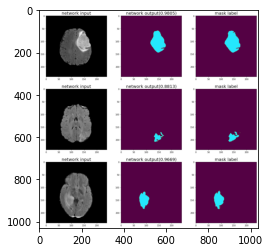

In [ ]:
img_2=cv2.imread('/content/evaluationow177_168_91.png')
print(img_2.shape)
img_3=cv2.imread('/content/evaluationow45_37_165.png')
print(img_3.shape)
img_4=cv2.imread('/content/evaluationow8_63_120.png')
print(img_4.shape)
# plt.imshow(img_2)
# plt.imshow(img_3)
plt.imshow(img_4,cmap='gray')
# 自行去目录查看文件来源。

In [ ]:
def dice_score(self, y_true, y_pred):
  predict = tf.reduce_sum(2 * y_true * tf.cast(tf.greater(y_pred, 0.1), tf.float32)) + 1e-8
  validation = tf.reduce_sum(y_true + tf.cast(tf.greater(y_pred, 0.1), tf.float32)) + 1e-8
  return predict / validation

In [ ]:
x_test = []
img_path = r'E:\XJTLU\IC\0.5\pred2'
all_files = os.listdir(img_path)
files = [item for item in all_files if "seg" in item]
for (n, file_name) in enumerate(files):
    img = np.load(os.path.join(img_path, file_name))
    img = np.uint8(img)
    np.save(os.path.join(img_path, file_name), img)
# 讲文件转换为uint8格式